In [1]:
import matplotlib.pyplot as plt
import networkx as nx

%matplotlib inline

In [2]:
net = nx.read_graphml("data/sheep_ml.graphml")

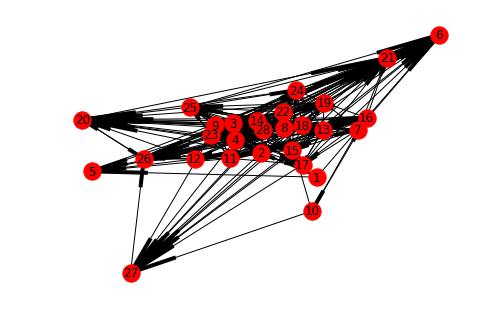

In [3]:
nx.draw_spring(net,with_labels=True)

In [4]:
net.adj

AdjacencyView({'1': {'2': {'weight': 1}, '3': {'weight': 1}, '4': {'weight': 1}, '5': {'weight': 1}, '6': {'weight': 1}}, '2': {'4': {'weight': 1}, '7': {'weight': 1}, '8': {'weight': 5}, '9': {'weight': 3}, '12': {'weight': 1}, '13': {'weight': 2}, '15': {'weight': 1}, '21': {'weight': 4}, '22': {'weight': 1}, '23': {'weight': 2}, '24': {'weight': 3}, '26': {'weight': 5}, '27': {'weight': 2}, '28': {'weight': 4}}, '3': {'2': {'weight': 1}, '4': {'weight': 1}, '5': {'weight': 1}, '6': {'weight': 5}, '8': {'weight': 1}, '9': {'weight': 7}, '14': {'weight': 7}, '15': {'weight': 5}, '16': {'weight': 2}, '18': {'weight': 3}, '19': {'weight': 5}, '20': {'weight': 6}, '21': {'weight': 1}, '23': {'weight': 8}, '24': {'weight': 2}, '25': {'weight': 3}, '26': {'weight': 4}, '28': {'weight': 1}}, '4': {'2': {'weight': 1}, '3': {'weight': 2}, '5': {'weight': 1}, '6': {'weight': 1}, '11': {'weight': 1}, '12': {'weight': 1}, '15': {'weight': 2}, '16': {'weight': 1}, '18': {'weight': 2}, '19': {'wei

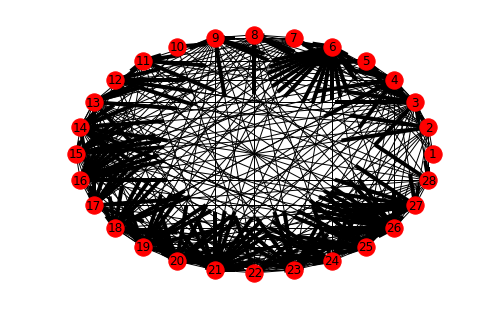

In [5]:
nx.draw_circular(net, with_labels=True)

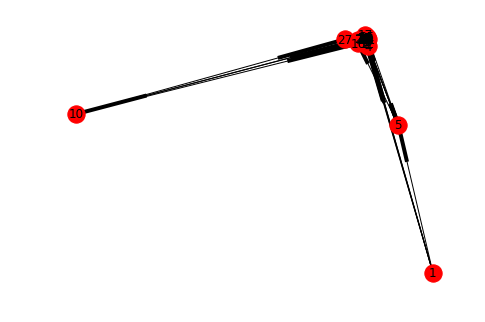

In [6]:
nx.draw_spectral(net, with_labels=True)

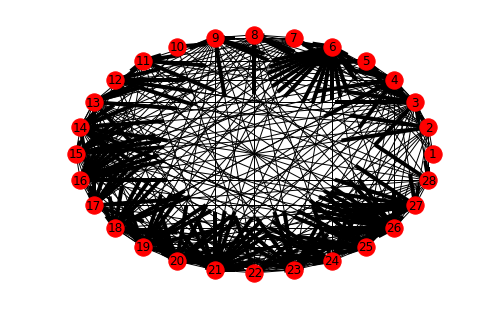

In [7]:
nx.draw_shell(net, with_labels=True)

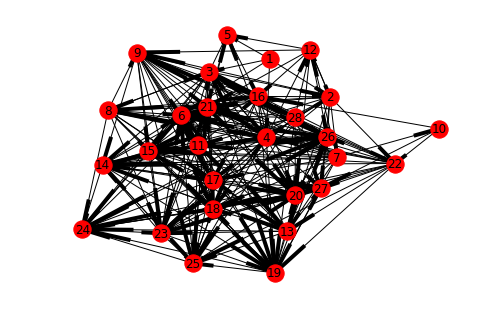

In [8]:
nx.draw_kamada_kawai(net,with_labels=True)

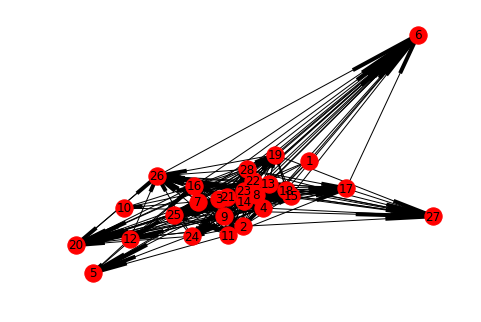

In [9]:
nx.draw(net,with_labels=True)

In [10]:
import json
from networkx.readwrite import json_graph

In [11]:
# Convert the node IDs from strings to integers for use in D3 script
net_int = nx.convert_node_labels_to_integers(net, first_label=0, ordering='default', label_attribute=None)

In [12]:
from networkx.readwrite import json_graph
data = json_graph.node_link_data(net_int)
with open('graph.json', 'w') as f:
    json.dump(data, f, indent=4)

In [13]:
%%html
<div id="sheep-viz"></div>
<style>
.node {stroke: #fff; stroke-width: 1.5px;}
.link {stroke: #999; stroke-opacity: .6;}
</style>

In [14]:
%%javascript
// We load the d3.js library from the Web.
require.config({paths: {d3: "http://d3js.org/d3.v3.min"}});
require(["d3"], function(d3) {
    // The code in this block is executed when the 
    // d3.js library has been loaded.
    
    // First, we specify the size of the canvas containing
    // the visualization (size of the <div> element).
    var width = 800,
        height = 600;

    // We create a color scale.
    var color = d3.scale.category10();

    // We create a force-directed dynamic graph layout.
    var force = d3.layout.force()
        .charge(-120)
        .linkDistance(width/4)
        .size([width, height]);

    // In the <div> element, we create a <svg> graphic
    // that will contain our interactive visualization.
    var svg = d3.select("#sheep-viz").select("svg")
    if (svg.empty()) {
        svg = d3.select("#sheep-viz").append("svg")
                    .attr("width", width)
                    .attr("height", height);
    }
        
    // We load the JSON file.
    d3.json("graph.json", function(error, graph) {
        // In this block, the file has been loaded
        // and the 'graph' object contains our graph.
        
        // We load the nodes and links in the force-directed
        // graph.
        force.nodes(graph.nodes)
            .links(graph.links)
            .start();

        // We create a <line> SVG element for each link
        // in the graph.
        var link = svg.selectAll(".link")
            .data(graph.links)
            .enter().append("line")
            .attr("class", "link");

        // We create a <circle> SVG element for each node
        // in the graph, and we specify a few attributes.
        var node = svg.selectAll(".node")
            .data(graph.nodes)
            .enter().append("circle")
            .attr("class", "node")
            .attr("r", function(d) {
                return d.age*2.0;
            })
            .style("fill", function(d) {
                return color(0);
            })
            .call(force.drag);

        // The name of each node is the node number.
        node.append("title")
            .text(function(d) { return "Sheep ID = " + (d.id + 1); });

        // We bind the positions of the SVG elements
        // to the positions of the dynamic force-directed graph,
        // at each time step.
        force.on("tick", function() {
            link.attr("x1", function(d) { return d.source.x; })
                .attr("y1", function(d) { return d.source.y; })
                .attr("x2", function(d) { return d.target.x; })
                .attr("y2", function(d) { return d.target.y; });

            node.attr("cx", function(d) { return d.x; })
                .attr("cy", function(d) { return d.y; });
        });
    });
});

<IPython.core.display.Javascript object>